<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Clean-Clean Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [19]:
!python --version

Python 3.7.6


In [31]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import (
    text_cleaning_method,
    print_clusters,
    print_blocks,
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation, write
from pyjedai.datamodel import Data
d1 = pd.read_csv("./data/ccer/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./data/ccer/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Block Building

In [32]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
)

from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding

In [33]:
qgb = SuffixArraysBlocking()
blocks = qgb.build_blocks(data, attributes_1=['name'], attributes_2=['name'])

Suffix Arrays Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

In [5]:
qgb.report()

Method name: Suffix Arrays Blocking
Method info: Creates one block for every suffix that appears in the attribute value tokens of at least two entities.
Parameters: 
	Suffix length: 6
	Maximum Block Size: 53
Attributes from D1:
	name
Attributes from D2:
	name
Runtime: 0.2735 seconds


#### EmbeddingsNNBlockBuilding

In [ ]:
emb = EmbeddingsNNBlockBuilding(
    vectorizer='bert',
    similarity_search='faiss'
)
blocks = emb.build_blocks(data)

In [ ]:
Evaluation(data).report(blocks, emb.method_configuration())

# Block Cleaning

In [36]:
from pyjedai.block_cleaning import BlockFiltering

In [37]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data, tqdm_disable=False)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

# Comparison Cleaning


In [38]:
from pyjedai.block_cleaning import BlockPurging

In [39]:
cbbp = BlockPurging()
cleaned_blocks = cbbp.process(filtered_blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/4632 [00:00<?, ?it/s]

In [40]:
cbbp.report()

Method name: Block Purging
Method info: Discards the blocks exceeding a certain number of comparisons.
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 600.0
Runtime: 0.1006 seconds


## Meta Blocking

In [41]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    ComparisonPropagation
)

In [42]:
wep = CardinalityEdgePruning(weighting_scheme='X2')
candidate_pairs_blocks = wep.process(filtered_blocks, data, tqdm_disable=True)

# Entity Matching

It compares pairs of entity profiles, associating every pair with a similarity in [0,1]. Its output comprises the similarity graph, i.e., an undirected, weighted graph where the nodes correspond to entities and the edges connect pairs of compared entities.

In [45]:
from pyjedai.matching import EntityMatching

In [46]:
EM = EntityMatching(
    metric='dice',
    similarity_threshold=0.4,
    attributes = ['description', 'name']
)

pairs_graph = EM.predict(candidate_pairs_blocks, data, tqdm_disable=True)

In [27]:
# pairs = write(pairs_graph, data)

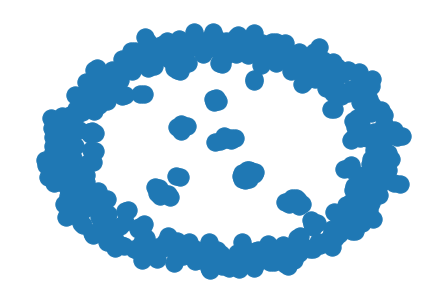

In [47]:
draw(pairs_graph)

# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [48]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [49]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph)

In [50]:
ccc.report()

Method name: Connected Components Clustering
Method info: Gets equivalence clusters from the transitive closure of the similarity graph.
Runtime: 0.0045 seconds


In [53]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering
umc = UniqueMappingClustering()
clusters = umc.process(pairs_graph)

Unique Mapping Clustering can only be performed in Clean-Clean Entity Resolution.
